### **Section I: Setup**

#### Importing all libraries

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import random
from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import tensorflow
import shutil
import datetime
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

#### Mounting google drive and changing directory

In [5]:
from google.colab import drive
drive._mount('/content/drive')  

os.chdir('/content/drive/MyDrive/ROB535_Perception_project')
print(os.getcwd())
df = pd.read_csv("classes.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ROB535_Perception_project


,class_id,class_name,label
0,0,Unknown,0
1,1,Compacts,1
2,2,Sedans,1
3,3,SUVs,1
4,4,Coupes,1


### **Section II: EDA and Directory structure**

#### Reference functions for EDA

In [ ]:
#Demo code to read data
def rot(n):
  """
  Taking a rotation vector n and returning the resultant rotation matrix
  """
  n = np.asarray(n).flatten()
  assert(n.size == 3)

  theta = np.linalg.norm(n)
  if theta:
    n /= theta
    K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

    return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
  else:
    return np.identity(3)

def get_bbox(p0, p1):
  """
  Input:
  * p0, p1
    (3)
    Corners of a bounding box represented in the body frame.

  Output:
  *   v
  (3, 8)
  Vertices of the bounding box represented in the body frame.
  * e
  (2, 14)
  Edges of the bounding box. The first 2 edges indicate the `front` side
  of the box.
  """
  v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]])
  
  e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]], dtype=np.uint8)

  return v, e

#Printing list of classes from classes.csv file
classes = (
    'Unknown', 'Compacts', 'Sedans', 'SUVs', 'Coupes',
    'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    'Boats', 'Helicopters', 'Planes', 'Service', 'Emergency',
    'Military', 'Commercial', 'Trains')

In [ ]:
#Getting all images in files
train_iles = sorted(glob('trainval/*/*_image.jpg'))

#Taking a random image and printing it
idx = np.random.randint(0, len(train_iles))
snapshot = train_iles[idx]
img = plt.imread(snapshot)
print(snapshot)
print(img.shape)

In [ ]:
#Getting point cloud for each image 
xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])

#Getting the camera projection matrix 'M' for each image 
proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

#Getting bounding box for each image
try:
    bbox = np.fromfile(snapshot.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
except FileNotFoundError:
    print('[*] bbox not found.')
    bbox = np.array([], dtype=np.float32)

bbox = bbox.reshape([-1, 11])

uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]

dist = np.linalg.norm(xyz, axis=0)
fig1 = plt.figure(1, figsize=(10, 7))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.imshow(img)
ax1.scatter(uv[0, :], uv[1, :], c=dist, marker='+', s=1)
ax1.axis('scaled')
fig1.tight_layout()

fig2 = plt.figure(2, figsize=(8, 8))
ax2 = Axes3D(fig2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

step = 5
ax2.scatter(
    xyz[0, ::step], xyz[1, ::step], xyz[2, ::step],
    c=dist[::step], marker='.', s=1
)

colors = ['C{:d}'.format(i) for i in range(10)]
for k, b in enumerate(bbox):
    R = rot(b[0:3])
    t = b[3:6]

    sz = b[6:9]
    vert_3D, edges = get_bbox(-sz / 2, sz / 2)
    vert_3D = R @ vert_3D + t[:, np.newaxis]

    vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
    vert_2D = vert_2D / vert_2D[2, :]

    clr = colors[np.mod(k, len(colors))]
    for e in edges.T:
        ax1.plot(vert_2D[0, e], vert_2D[1, e], color=clr)
        ax2.plot(vert_3D[0, e], vert_3D[1, e], vert_3D[2, e], color=clr)

    c = classes[int(b[9])]
    ignore_in_eval = bool(b[10])
    if ignore_in_eval:
        ax2.text(t[0], t[1], t[2], c, color='r')
    else:
        ax2.text(t[0], t[1], t[2], c)

ax2.auto_scale_xyz([-40, 40], [-40, 40], [0, 80])
ax2.view_init(elev=-30, azim=-90)

for e in np.identity(3):
    ax2.plot([0, e[0]], [0, e[1]], [0, e[2]], color=e)

plt.show()

In [ ]:
def img2classname(img_path):
  """
  Obtain image class name based on input image path
  Using classes.csv file
  """
  bbox = np.fromfile(img_path.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
  bbox = bbox.reshape([-1, 11])
  class_id = int(bbox[:,-2])
  return id2name_dict[class_id]

#Plotting multiple images in the test set
# Set up matplotlib fig, and size it to fit 4x4 pics
def plot_multiple_images(nrows, ncols, image_path_files):
  ncols = ncols
  nrows = nrows
  fig = plt.gcf()
  fig.set_size_inches(14, 10)
  idx_list = random.sample(range(1, len(image_path_files)), 20)

  car_pix = [image_path_files[idx] for idx in idx_list]

  for i, img_path in tqdm_notebook(enumerate(car_pix)):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = plt.imread(img_path)
    plt.imshow(img)

  plt.show()

plot_multiple_images(4, 5, train_iles)

In [ ]:
#Creating mapping dictionaries for output label class and class names
id2label_dict = {id:int(df[df.class_id == id].label) for id in df.class_id}
label2classes_dict = {0: "Unknown_and_Others",
                      1: "Cars",
                      2: "Other_modes_of_transport"}

#Reference functions to copy images into their respective directories
def img2classid(img_path):
  bbox = np.fromfile(img_path.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
  bbox = bbox.reshape([-1, 11])
  class_id = int(bbox[:,-2])
  return id2label_dict[class_id]

#Creating training and testing datasets 
def create_train_dataset(img_path_file, resize_dim):
  data_list = []
  label_list = []
  for fname in tqdm_notebook(img_path_file):
    arr = np.array(Image.open(fname).resize((resize_dim, resize_dim)))
    data_list.append(arr)
    label_list.append(img2classid(fname))
  return np.array(data_list), np.array(label_list)

In [ ]:
#Printing training data and label shape
print("The number of images in the dataset = {}".format(train_X.shape[0]))
print("Size of each training dataset = {}".format(train_X.shape))
print("Size of each image = {}".format(train_X.shape[1:]))
assert train_X.shape[0] == train_y.shape[0]

In [ ]:
#Getting the class distribution dictionary

def class_counts(img_file_path):
  counts = {}

  for fname in tqdm_notebook(img_file_path):
    name = img2classname(fname)
    if name not in counts:
      counts[name] = 1
    else:
      counts[name] += 1
  return counts

#Obtaining the distribution of classes in training set
class_distribution = class_counts(train_files)

  0%|          | 0/7573 [00:00<?, ?it/s]

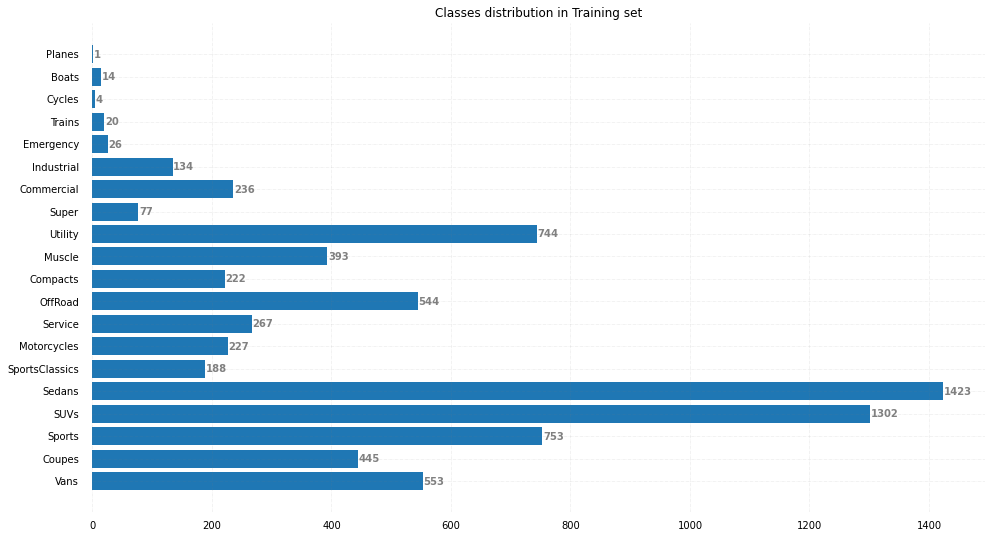

In [ ]:
#Plotting bar graph of class distributions in Training set
class_names = list(class_distribution.keys())
num_class = list(class_distribution.values())
  
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(class_names, num_class)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

for i in ax.patches:
    plt.text(i.get_width()+1, i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Classes distribution in Training set', fontsize=12)

plt.show()

#### Creating Image directory structure for using ImageDataGenerator class

In [ ]:
#Reference class categorisation for pre processing into directories
"""unknown/ Boats/ helicopters/ planes/ trains -- Unknown and Others
compacts/ sedans/ suvs/ coupes/ muscle/ sportsclassics/ sports/ super -- Cars
Motorcycles/ cycles -- 2 Wheeler
Offroad -- Offroad
Industrial -- Industrial
Utility, Vans -- Utility
Service/ Emergency/ Military -- Service
Commercial -- Commercial"""

#Creating directory structure for ImageDataGenerator class
try:
    os.mkdir('Preprocessed_Task1')
    base_dir = os.path.join(os.getcwd(), 'Preprocessed_Task1')

    #Creating classes directory within training
    train_unknown_dir = os.path.join(base_dir, "Unknown_and_Others")
    train_car_dir = os.path.join(base_dir, "Cars")
    train_2wheeler_dir = os.path.join(base_dir, "2_Wheeler")
    train_offroad_dir = os.path.join(base_dir, "Offroad")
    train_industrial_dir = os.path.join(base_dir, "Industrial")
    train_utility_dir = os.path.join(base_dir, "Utility")
    train_service_dir = os.path.join(base_dir, "Service")
    train_commercial_dir = os.path.join(base_dir, "Commercial")

    os.mkdir(train_unknown_dir)
    os.mkdir(train_car_dir)
    os.mkdir(train_2wheeler_dir)
    os.mkdir(train_offroad_dir)
    os.mkdir(train_industrial_dir)
    os.mkdir(train_utility_dir)
    os.mkdir(train_service_dir)
    os.mkdir(train_commercial_dir)

except OSError as error:
    print(error)
print('Successfully created directory structure!!')

Successfully created directory structure!!


In [ ]:
#Creating mapping dictionaries for output label class and class names
id2label_dict = {id:int(df[df.class_id == id].label) for id in df.class_id}
id2name_dict = {id:df[df.class_id == id].class_name.tolist()[0] for id in df.class_id}

#Reference functions created
def img2classid(img_path):
  """
  Getting image class id for classes.csv file based on input image path
  """
  bbox = np.fromfile(img_path.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
  bbox = bbox.reshape([-1, 11])
  class_id = int(bbox[:,-2])
  return id2label_dict[class_id]

def select_class_dir(image_file, class_name):

  """
  Uses the shutil module to copy files in the image folder 
  Copied into respective directories based on class name 
  """
  if class_name == "Compacts" or class_name == "Sedans" or class_name == "SUVs" or class_name == "Coupes" or class_name == "Muscle" or class_name == "SportsClassics" or class_name == "Sports" or class_name == "Super":
    shutil.copy(image_file, train_car_dir) 
    #Renaming the file on the file
    os.rename(os.path.join(train_car_dir, image_file[-14:]),
              os.path.join(train_car_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))

  elif class_name == "Unknown" or class_name == "Boats" or class_name == "Helicopters" or class_name == "Planes" or class_name == "Trains":
    shutil.copy(image_file, train_unknown_dir)
    #Renaming the file on the file
    os.rename(os.path.join(train_unknown_dir, image_file[-14:]),
                  os.path.join(train_unknown_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))

  elif class_name == "Motorcycles" or class_name == "Cycles":
    shutil.copy(image_file, train_2wheeler_dir)
    #Renaming the file on the file
    os.rename(os.path.join(train_2wheeler_dir, image_file[-14:]),
                  os.path.join(train_2wheeler_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))
        
  elif class_name == "OffRoad":
    shutil.copy(image_file, train_offroad_dir)
    #Renaming the file on the file
    os.rename(os.path.join(train_offroad_dir, image_file[-14:]),
                  os.path.join(train_offroad_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))
        
  elif class_name == "Industrial":
        shutil.copy(image_file, train_industrial_dir)
        #Renaming the file on the file
        os.rename(os.path.join(train_industrial_dir, image_file[-14:]),
                  os.path.join(train_industrial_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))
        
    elif class_name == "Commercial":
        shutil.copy(image_file, train_commercial_dir)
        #Renaming the file on the file
        os.rename(os.path.join(train_commercial_dir, image_file[-14:]),
                  os.path.join(train_commercial_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))

    elif class_name == "Utility" or class_name == "Vans":
        shutil.copy(image_file, train_utility_dir)
        #Renaming the file on the file
        os.rename(os.path.join(train_utility_dir, image_file[-14:]),
                  os.path.join(train_utility_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))
        
    elif class_name == "Service" or class_name == "Emergency" or class_name == "Military":
        shutil.copy(image_file, train_service_dir)
        #Renaming the file on the file
        os.rename(os.path.join(train_service_dir, image_file[-14:]),
                  os.path.join(train_service_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))

#Copying files from the trainval folder to each subfolder depending upon class label
def copy_data_into_dir(img_path_file):

  """
  References the above functions to create the image directory structure
  """
    for fname in tqdm_notebook(img_path_file):
        class_name = img2classname(fname)
        select_class_dir(fname, class_name)

#Running the copying images function
copy_data_into_dir(train_files)
print('Successfully copied all files into respective directories')

  0%|          | 0/7573 [00:00<?, ?it/s]

Successfully copied all files into respective directories


In [ ]:
base_dir = os.path.join(os.getcwd(), 'Preprocessed_Task1')
train_unknown_dir = os.path.join(base_dir, "Unknown_and_Others")
train_car_dir = os.path.join(base_dir, "Cars")
train_2wheeler_dir = os.path.join(base_dir, "2_Wheeler")
train_offroad_dir = os.path.join(base_dir, "Offroad")
train_industrial_dir = os.path.join(base_dir, "Industrial")
train_utility_dir = os.path.join(base_dir, "Utility")
train_service_dir = os.path.join(base_dir, "Service")
train_commercial_dir = os.path.join(base_dir, "Commercial")

#Printing results to crosscheck successful file transfer
print("The number of Class: {} = {}".format("Unknown_and_Others", len(os.listdir(train_unknown_dir))))
print("The number of Class: {} = {}".format("Cars", len(os.listdir(train_car_dir))))
print("The number of Class: {} = {}".format("2_Wheeler", len(os.listdir(train_2wheeler_dir))))
print("The number of Class: {} = {}".format("Offroad", len(os.listdir(train_offroad_dir))))
print("The number of Class: {} = {}".format("Industrial", len(os.listdir(train_industrial_dir))))
print("The number of Class: {} = {}".format("Utility", len(os.listdir(train_utility_dir))))
print("The number of Class: {} = {}".format("Service", len(os.listdir(train_service_dir))))
print("The number of Class: {} = {}".format("Commercial", len(os.listdir(train_commercial_dir))))

The number of Class: Unknown_and_Others = 35
The number of Class: Cars = 4803
The number of Class: 2_Wheeler = 231
The number of Class: Offroad = 544
The number of Class: Industrial = 134
The number of Class: Utility = 1298
The number of Class: Service = 293
The number of Class: Commercial = 236


### **Section III: Defining Data Loaders in Tensorflow**

#### Checking GPU and Ram availability

In [ ]:
#Checking GPU availablity
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 13 05:57:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


#### Loading images from directories using ImageDataGenerator class

In [ ]:
#Creating ImageDataGenerators for training, validation sets
base_dir = os.path.join(os.getcwd(), "Preprocessed_Task1")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
res_size = 224
classes_ls = ["Unknown_and_Others", "Cars", "2_Wheeler", "Offroad", "Industrial", "Utility", "Service", "Commercial"]

train_datagen = ImageDataGenerator(height_shift_range=0.15, fill_mode='nearest',
                                   horizontal_flip=True, rescale=1.0/255., validation_split=0.15)

train_generator = train_datagen.flow_from_directory(
                  base_dir, target_size=(res_size, res_size), color_mode='rgb',
                  classes = classes_ls,
                  class_mode='categorical', batch_size=64, shuffle=True,
                  subset="training", interpolation='bilinear')

val_generator = train_datagen.flow_from_directory(
                base_dir, target_size=(res_size, res_size), color_mode='rgb',
                classes = classes_ls,
                class_mode='categorical', batch_size=64, shuffle=True,
                subset="validation", interpolation='bilinear')

Found 6441 images belonging to 8 classes.
Found 1132 images belonging to 8 classes.


### **Section IV: Training models using Transfer Learning**

#### Using Transfer Learning with ResNet50v2 model

In [ ]:
#Loading a ResNet50v2 model
from tensorflow.keras import layers
from tensorflow.keras import Model
res_size = 224
from tensorflow.keras.applications.resnet_v2 import ResNet50V2


res_model = ResNet50V2(include_top = False, weights='imagenet',
                      input_shape=(res_size, res_size, 3))

In [ ]:
for layer in res_model.layers[:130]:
  layer.trainable = False

last_layer = res_model.get_layer("conv5_block3_2_relu")
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Flatten the output layer to 1 dimension
#x = layers.Flatten()(last_output)
x = layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(rate = 0.2)(x)

# Add a fully connected layer 
x = layers.Dense(256, activation='relu', use_bias=True,
                 kernel_initializer = tf.keras.initializers.HeNormal(),
                 bias_initializer='zeros')(x)

x = tf.keras.layers.BatchNormalization()(x)

# Add a fully connected layer 
x = layers.Dense(128, activation='relu', use_bias=True,
                 kernel_initializer = tf.keras.initializers.HeNormal(),
                 bias_initializer='zeros')(x)

x = tf.keras.layers.BatchNormalization()(x)

x = layers.Dense(32, activation='relu', use_bias=True,
                 kernel_initializer = tf.keras.initializers.HeNormal(),
                 bias_initializer='zeros')(x)

# Add a final sigmoid layer for classification
x = layers.Dense(len(os.listdir(base_dir)), activation = "softmax")(x)           

resnetv2_model = Model(res_model.input, x) 
resnetv2_model.summary()

In [ ]:
#Compiling the model
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=5e-3)
loss = tensorflow.keras.losses.CategoricalCrossentropy()

resnetv2_model.compile(optimizer = opt, 
                       loss = loss, 
                       metrics = ["accuracy"])

lor = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.3, patience=3, verbose=1,
    mode='auto', min_delta=0.05, min_lr=0)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "training_ResNetV2-{epoch:03d}.h5", monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only = False, save_freq='epoch')

history = resnetv2_model.fit(
            train_generator,
            validation_data = val_generator,
            epochs = 7, 
            verbose = 1, shuffle=True,
            callbacks = [lor, checkpoint])

#### Testing model performance

In [ ]:
def create_test_dataset(test_img_path_file, resize_dim):
  """
  Creates a numpy file in format (test_num, Res50 input, Res50 input, 3)
  Used to test the model performance later
  """
    data_list = []
    for fname in tqdm_notebook(test_img_path_file):
        arr = np.array(Image.open(fname).resize((resize_dim, resize_dim)))
        data_list.append(arr)    
    return data_list

res_size = 224
test_files = sorted(glob('test/*/*_image.jpg'))
res_test_X = create_test_dataset(test_files, res_size)
np.save("res_test_x.npy", res_test_X)

  0%|          | 0/2631 [00:00<?, ?it/s]

In [ ]:
#Creating test_set for EfficientNetB4 
def create_test_dataset(test_img_path_file, resize_dim):
    data_list = []
    for fname in tqdm_notebook(test_img_path_file):
        arr = np.array(Image.open(fname).resize((resize_dim, resize_dim)))
        data_list.append(arr)    
    return data_list

effv2s_size = 384
test_files = sorted(glob('test/*/*_image.jpg'))
effv2s_test_X = create_test_dataset(test_files, effv2s_size)
np.save("effv2s_test_x.npy", effv2s_test_X)

  0%|          | 0/2631 [00:00<?, ?it/s]

In [ ]:
#Testing performance
#Loading test dataset images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_X = np.array(np.load("res_test_x.npy"))
test_datagen = ImageDataGenerator(rescale=1.0/255.)

test_generator = test_datagen.flow(test_X, batch_size = 32, shuffle=False)

In [ ]:
#Loading resnetv2 model
from tensorflow.keras.models import load_model
checkpoint_path = "/content/drive/MyDrive/ROB535_Perception_project/training_2-048.h5"
test_resnetv2101_model = load_model(checkpoint_path)

test_files = sorted(glob('test/*/*_image.jpg'))
#Obtain predictions from the test data
print("Dimensions of the predictions array: {}".format(predictions.shape))
assert predictions.shape[0] == np.array(test_X).shape[0]

Dimensions of the predictions array: (2631, 8)


In [ ]:
test_files = sorted(glob('test/*/*_image.jpg'))
np.save("test_files.npy", np.array(test_files))
print("File saved")

File saved


#### Post processing and submitting csv file

In [ ]:
#Transforming labels to appropriate classes for csv submission
def convert_label(label):
  """
  Tranforming label to match final output class 
  """
  if label == 3 or label == 4 or label == 5:
    return 2
  elif label == 6 or label == 7:
    return 0
  else:
    return label

predictions_ls = [convert_label(label) for label in np.argmax(predictions, axis=1).tolist()]

In [ ]:
#Creating a dataframe and saving it as output
test_file = [fname[5:-10] for fname in test_files]
data = {'guid/image': test_file, 'label': predictions_ls}
output_df = pd.DataFrame(data)
output_df.to_csv("ResNetv2101_preprocessed_Team11.csv", index=False)

In [ ]:
from tensorflow.keras.models import load_model
test_files = sorted(glob('test/*/*_image.jpg'))

def test_model_performance_with_hub(model_path, csv_file_name):
  """
  Saves an apt Kaggle competition submission csv file baed on tf model and csv file name
  """
  checkpoint_path = model_path
  test_model = load_model(checkpoint_path, custom_objects={'KerasLayer':hub.KerasLayer})

  #Obtain predictions from the test data
  predictions = test_model.predict(test_generator)
  print("Dimensions of the predictions array: {}".format(predictions.shape))
  assert predictions.shape[0] == np.array(test_X).shape[0]
  predictions_ls = [convert_label(label) for label in np.argmax(predictions, axis=1).tolist()]

  #Creating a dataframe and saving it as output
  test_file = [fname[5:-10] for fname in test_files]
  data = {'guid/image': test_file, 'label': predictions_ls}
  output_df = pd.DataFrame(data)
  output_df.to_csv(csv_file_name, index=False)
  print("File_downloaded as .csv!!")

In [ ]:
test_model_performance(model_path = "/content/drive/MyDrive/ROB535_Perception_project/Efficientv2B0_training-049.h5",
                       csv_file_name = "Effv2B0_Team11.csv")

Dimensions of the predictions array: (2631, 8)
File_downloaded as .csv!!


#### Evaluating ResNet50v2 model performance of validation set

In [ ]:
#Loading resnetv2 model
from tensorflow.keras.models import load_model
checkpoint_path = "/content/drive/MyDrive/ROB535_Perception_project/training_ResNetV2-046.h5"
test_resnetv50_model = load_model(checkpoint_path)

In [ ]:
val_loss, val_accuracy = test_resnetv502_model.evaluate(val_generator, verbose=1)

18/18 [==============================] - 483s 28s/step - loss: 1.2585 - accuracy: 0.6908


#### Complete pipeline -- Training the ResNet50 v2 model with small learning rates -- Tuning model performance

In [ ]:
#Loading resnetv2 model
from tensorflow.keras.models import load_model
checkpoint_path = "/content/drive/MyDrive/ROB535_Perception_project/training_ResNetV2-046.h5"
test_resnetv250_model = load_model(checkpoint_path)

In [ ]:
base_dir2 = os.path.join(os.getcwd(), "Preprocessed_Task1")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
res_size = 224
classes_ls = ["Unknown_and_Others", "Cars", "2_Wheeler", "Offroad", "Industrial", "Utility", "Service", "Commercial"]

train_datagen = ImageDataGenerator(height_shift_range=0.15, fill_mode='nearest',
                                   horizontal_flip=True, rescale=1.0/255., validation_split=0.15,
                                   width_shift_range=0.1, brightness_range=(0.3, 0.7), zoom_range=0.1,
                                   rotation_range = 10, shear_range=0.1)

train_generator = train_datagen.flow_from_directory(
                  base_dir2, target_size=(res_size, res_size), color_mode='rgb',
                  classes = classes_ls,
                  class_mode='categorical', batch_size=64, shuffle=True,
                  subset="training", interpolation='lanczos')

val_generator = train_datagen.flow_from_directory(
                base_dir2, target_size=(res_size, res_size), color_mode='rgb',
                classes = classes_ls,
                class_mode='categorical', batch_size=64, shuffle=True,
                subset="validation", interpolation='lanczos')

Found 6441 images belonging to 8 classes.
Found 1132 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=3e-6)
loss = tensorflow.keras.losses.CategoricalCrossentropy()

with tf.device('/gpu:0'):
    test_resnetv250_model.compile(optimizer = opt, 
                       loss = loss, 
                       metrics = ["accuracy"])

    lor = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=0.25, patience=3, verbose=1,
        mode='auto', min_delta=0.01, min_lr=1e-13)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "ResNetv250_training/training-{epoch:03d}-{val_loss:.4f}-{val_accuracy:.4f}.h5",
        monitor='val_accuracy', verbose=1, save_best_only=True,
        save_weights_only = False, save_freq='epoch')

    history2 = test_resnetv250_model.fit(
            train_generator,
            validation_data = val_generator,
            epochs = 25, 
            verbose = 1, shuffle=True,
            callbacks = [lor, checkpoint])

In [ ]:
#Transforming labels to appropriate classes for csv submission
def convert_label(label):
  if label == 3 or label == 4 or label == 5:
    return 2
  elif label == 6 or label == 7:
    return 0
  else:
    return label

def test_model_performance_without_hub(model_path, csv_file_name):
  checkpoint_path = model_path
  test_model = load_model(checkpoint_path)

  #Obtain predictions from the test data
  predictions = test_model.predict(test_generator)
  print("Dimensions of the predictions array: {}".format(predictions.shape))
  assert predictions.shape[0] == np.array(test_X).shape[0]
  predictions_ls = [convert_label(label) for label in np.argmax(predictions, axis=1).tolist()]

  #Creating a dataframe and saving it as output
  test_file = [fname[5:-10] for fname in test_files]
  data = {'guid/image': test_file, 'label': predictions_ls}
  output_df = pd.DataFrame(data)
  output_df.to_csv(csv_file_name, index=False)
  print("File_downloaded as .csv!!")

In [ ]:
test_model_performance_without_hub("/content/drive/MyDrive/ROB535_Perception_project/ResNetv250_training/training-023-1.3107-0.7323.h5",
                                    "ResNetv250_small_lr_Team11.csv")

Dimensions of the predictions array: (2631, 8)
File_downloaded as .csv!!


In [6]:
#Transforming labels to appropriate classes for csv submission
def convert_label(label):
  if label == 3 or label == 4 or label == 5:
    return 2
  elif label == 6 or label == 7:
    return 0
  else:
    return label

def sub_model_label(label):
  if label == 0:
    return 2
  else:
    return label

classes_ls = ["Unknown_and_Others", "Cars", "2_Wheeler", "Offroad", "Industrial", "Utility", "Service", "Commercial"]
os.chdir("/content/drive/MyDrive/ROB535_Task1")

#Defining custom test generator with soft voting
def custom_augmentation_testgen(test_npy_file, 
                                saved_full_model_path,
                                saved_subset_model_path1,
                                saved_subset_model_path2,
                                test_files,
                                csv_file_name):
  
  """
  Inputs:
  test_npy_file: Input numpy file which contains test images in form (batch, size, size, channel_size)
  Use np.load("test_npy_file") to use it for custom generator

  saved_full_model_path: Full 8 classes classifier model path

  saved_subset_model_path1: Cars, Offroad and Utility class classfier model path
  Preferred when class label is Cars or Utility

  saved_subset_model_path2: Second Cars, Offroad and Utility class classfier model path 
  Preferred when class label is Offroad

  test_files: Test files loaded using glob from the directory -- Used to create column in DataFrame

  csv_file_name: Output csv file name to store the submission 

  Output: Submission csv file to upload on Kaggle
  """

  #Aggregating predictions on each test image
  prediction_ls = []
    
  #Used for prioritizing between stacked Image Classifier and Object Detection model -- 0/1
  flag_label = []

  #Loading saved full model
  checkpoint_path = saved_full_model_path
  test_model_1 = load_model(checkpoint_path, custom_objects={'KerasLayer':hub.KerasLayer})

  #Loading saved subset model 1 -- Trained on Cars, Offroad and Utility class only 
  #Preferred when class is Cars or Utility
  checkpoint_path2 = saved_subset_model_path1
  test_model_2 = load_model(checkpoint_path2, custom_objects={'KerasLayer':hub.KerasLayer})

  #Loading saved subset model 2 -- Trained on Cars, Offroad and Utility class only
  #Preferred when class is Offroad
  checkpoint_path3 = saved_subset_model_path2
  test_model_3 = load_model(checkpoint_path3, custom_objects={'KerasLayer':hub.KerasLayer})

  for img in tqdm_notebook(test_npy_file):
    #Stacking 6 rescaled images - the original, random shift 0.1*x & 0.1*y, random rotation 10 degrees,
    #                             random brightness, random zoom 0.1 and random shear - intensity 8
    batch_img = np.vstack((img[np.newaxis, :]/255,
                          
                          tf.keras.preprocessing.image.random_shift(
                          img, wrg = 0.1, hrg = 0.1, row_axis=0,
                          col_axis=1, channel_axis=2)[np.newaxis, :]/255, 
                          
                          tf.keras.preprocessing.image.random_rotation(
                          img, rg = 10, row_axis=0,
                          col_axis=1, channel_axis=2)[np.newaxis, :]/255,

                          tf.keras.preprocessing.image.random_brightness(
                          img, brightness_range = (0.3,0.7))[np.newaxis, :]/255,

                          tf.keras.preprocessing.image.random_zoom(
                          img, zoom_range = (0.1,0.1), row_axis=0,
                          col_axis=1, channel_axis=2)[np.newaxis, :]/255, 

                          tf.keras.preprocessing.image.random_shear(
                          img, intensity = 8, row_axis=0,
                          col_axis=1, channel_axis=2)[np.newaxis, :]/255                                   
                          ))
    
    #Checking whether the batch_img is valid or not
    assert batch_img.shape[0] == 6

    #Obtain predictions from the batch Image data
    predictions = test_model_1.predict(batch_img)
    assert predictions.shape[0] == batch_img.shape[0]

    #Performing soft voting based on probabilities -- single classifier
    final_label = np.argmax(np.average(predictions, axis=0))
    img_class = classes_ls[final_label]

    #Building stacking classifier if predicted is either Cars, Offroad or Utility class 
    if img_class == "Cars" or img_class == "Utility":
      
      #Predicting using seperate subset classifier 1 trained on these 3 classes 
      pred = test_model_2.predict(batch_img)
      assert pred.shape[0] == batch_img.shape[0]

      #Implementing soft voting and appending the predicted label
      label = np.argmax(np.average(pred, axis=0))
      prediction_ls.append(sub_model_label(label))
      flag_label.append(1)

    elif img_class == "Offroad":

      #Predicting using seperate subset classifier 1 trained on these 3 classes 
      pred = test_model_3.predict(batch_img)
      assert pred.shape[0] == batch_img.shape[0]

      #Implementing soft voting and appending the predicted label
      label = np.argmax(np.average(pred, axis=0))
      prediction_ls.append(sub_model_label(label))
      flag_label.append(1)

    else:
      prediction_ls.append(convert_label(final_label))
      flag_label.append(0)

  #Creating a dataframe and saving it as output
  assert len(prediction_ls) == test_npy_file.shape[0]

  #Based on submission regulations
  image_file = [fname[5:-10] for fname in test_files]
  data = {'guid/image': image_file, 'label': prediction_ls, 'flag':flag_label}
  
  #Creating the pandas DataFrame and saving it
  output_df = pd.DataFrame(data)
  output_df.to_csv(csv_file_name, index=False)
  print("File_downloaded as .csv!!")

#Running the function
test_npy_file = np.load("effv2s_test_x.npy") #Contains each image of dim (384,384,3) -- Input for EfficientV2s model
model_path = "Models/training-017-0.9035-0.7473.h5"
model_path2 = "Models/training-001-0.7265-0.7889.h5"
model_path3 = "Models/training-016-0.7580-0.7930.h5"
test_files = sorted(glob('test/*/*_image.jpg'))
file_name = "Stacked_EfficientV2s_softVoting_Team11_flag.csv"

custom_augmentation_testgen(test_npy_file = test_npy_file,
                            saved_full_model_path = model_path,
                            saved_subset_model_path1 = model_path2,
                            saved_subset_model_path2 = model_path3,
                            test_files = test_files,
                            csv_file_name = file_name)

  0%|          | 0/2631 [00:00<?, ?it/s]

File_downloaded as .csv!!


In [ ]:
#Printing results
base_dir = os.path.join(os.getcwd(), 'Preprocessed_subset_Task1')
train_car_dir = os.path.join(base_dir, "Cars")
train_offroad_dir = os.path.join(base_dir, "Offroad")
train_utility_dir = os.path.join(base_dir, "Utility")

#Printing results to crosscheck successful file transfer
print("The number of Class: {} = {}".format("Cars", len(os.listdir(train_car_dir))))
print("The number of Class: {} = {}".format("Offroad", len(os.listdir(train_offroad_dir))))
print("The number of Class: {} = {}".format("Utility", len(os.listdir(train_utility_dir))))

The number of Class: Cars = 4803
The number of Class: Offroad = 544
The number of Class: Utility = 1297


### **Section V: Developing sub classifiers based on Error Analysis**

#### Training a seperate classifier on Cars, Utility and Commerical vehicles

In [ ]:
#Creating directory strucuture to run ImageDataGenerator
#Creating directory structure for ImageDataGenerator class
try:
    os.mkdir('Preprocessed_subset_Task1')
    base_dir = os.path.join(os.getcwd(), 'Preprocessed_subset_Task1')

    #Creating classes directory within training
    train_car_dir = os.path.join(base_dir, "Cars")
    train_offroad_dir = os.path.join(base_dir, "Offroad")
    train_utility_dir = os.path.join(base_dir, "Utility")

    os.mkdir(train_car_dir)
    os.mkdir(train_offroad_dir)
    os.mkdir(train_utility_dir)

except OSError as error:
    print(error)
print('Successfully created directory structure!!')

Successfully created directory structure!!


In [ ]:
def select_class_subset_dir(image_file, class_name):
    
    if class_name == "Compacts" or class_name == "Sedans" or class_name == "SUVs" or class_name == "Coupes" or class_name == "Muscle" or class_name == "SportsClassics" or class_name == "Sports" or class_name == "Super":
        shutil.copy(image_file, train_car_dir) 
        #Renaming the file on the file
        os.rename(os.path.join(train_car_dir, image_file[-14:]),
                  os.path.join(train_car_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))
        
    elif class_name == "OffRoad":
        shutil.copy(image_file, train_offroad_dir)
        #Renaming the file on the file
        os.rename(os.path.join(train_offroad_dir, image_file[-14:]),
                  os.path.join(train_offroad_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))

    elif class_name == "Utility" or class_name == "Vans":
        shutil.copy(image_file, train_utility_dir)
        #Renaming the file on the file
        os.rename(os.path.join(train_utility_dir, image_file[-14:]),
                  os.path.join(train_utility_dir, image_file[-14:-4] + str(datetime.datetime.now())[11:]+'.jpg'))

#Copying files from the trainval folder to each subfolder depending upon class label
def copy_data_subset_dir(img_path_file):
    for fname in tqdm_notebook(img_path_file):
        class_name = img2classname(fname)
        select_class_subset_dir(fname, class_name)

#Running the copying images function
copy_data_subset_dir(train_files)
print('Successfully copied all files into respective directories')

  0%|          | 0/7573 [00:00<?, ?it/s]

Successfully copied all files into respective directories


In [ ]:
#Training EfficientNetV2s on the subset preprocessed dataset 
base_dir2 = os.path.join(os.getcwd(), "Preprocessed_subset_Task1")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
effv2s_size = 384
classes_ls = ["Offroad","Cars","Utility"]

train_datagen = ImageDataGenerator(height_shift_range=0.15, fill_mode='nearest',
                                   horizontal_flip=True, rescale=1.0/255., validation_split=0.15,
                                   width_shift_range=0.15, brightness_range=(0.3, 0.7), zoom_range=0.1,
                                   rotation_range = 10, shear_range=0.1)

train_generator = train_datagen.flow_from_directory(
                  base_dir2, target_size=(effv2s_size, effv2s_size), color_mode='rgb',
                  classes = classes_ls,
                  class_mode='categorical', batch_size=16, shuffle=True,
                  subset="training", interpolation='lanczos')

val_generator = train_datagen.flow_from_directory(
                base_dir2, target_size=(effv2s_size, effv2s_size), color_mode='rgb',
                classes = classes_ls, 
                class_mode='categorical', batch_size=16, shuffle=True,
                subset="validation", interpolation='lanczos')

Found 5649 images belonging to 3 classes.
Found 995 images belonging to 3 classes.


In [ ]:
#Loading the EfficientNetv2s model
effv2s_size = 384
do_fine_tuning = True
base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2",
                            trainable = do_fine_tuning)

effv2s_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(effv2s_size, effv2s_size,3)),
    base_model,

    # Add a fully connected layer 
    tf.keras.layers.Dense(512, activation='relu', use_bias=True,
                 kernel_initializer = tf.keras.initializers.HeNormal(),
                 bias_initializer='zeros'),

    # Add another fully connected layer 
    tf.keras.layers.Dense(256, activation='relu', use_bias=True,
                 kernel_initializer = tf.keras.initializers.HeNormal(),
                 bias_initializer='zeros'),

    # Add another fully connected layer 
    tf.keras.layers.Dense(64, activation='relu', use_bias=True,
                 kernel_initializer = tf.keras.initializers.HeNormal(),
                 bias_initializer='zeros'),
    
    # Add a final sigmoid layer for classification
    tf.keras.layers.Dense(3, activation = "softmax")])         

effv2s_model.build((None, effv2s_size, effv2s_size, 3))

In [ ]:
from tensorflow.keras.models import load_model
checkpoint_path = "EfficientV2s_subset_training/training-013-0.7522-0.7899.h5"

effv2s_model = load_model(checkpoint_path, custom_objects={'KerasLayer':hub.KerasLayer})

#Compiling the model
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=1e-4)
loss = tensorflow.keras.losses.CategoricalCrossentropy()

effv2s_model.compile(optimizer = opt, 
                     loss = loss, 
                     metrics = ["accuracy"])

lor = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy', factor=0.25, patience=3, verbose=1,
        mode='auto', min_delta=0.01, min_lr=1e-12)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "EfficientV2s_subset_training/training-{epoch:03d}-{val_loss:.4f}-{val_accuracy:.4f}.h5",
        monitor='val_accuracy', verbose=1, save_best_only=True,
        save_weights_only = False, save_freq='epoch')

history3 = effv2s_model.fit(
                            train_generator,
                            validation_data = val_generator,
                            epochs = 30, 
                            verbose = 1, shuffle=True,
                            callbacks = [lor, checkpoint]
                            )

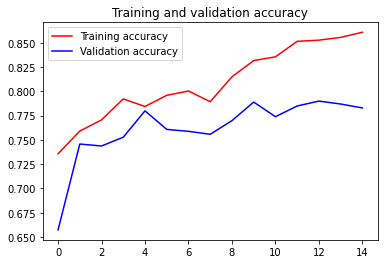

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### **Section VI: Experimentation**


In [ ]:
from tensorflow.keras.models import load_model

def re_train_model(checkpoint_path, lr):
  new_model = load_model(checkpoint_path)

  opt = Adam(learning_rate = lr)
  loss = tensorflow.keras.losses.CategoricalCrossentropy()

  new_model.compile(optimizer = opt, 
                    loss = loss, 
                    metrics = ["accuracy"])
  return new_model

path = "/content/drive/MyDrive/ROB535_Perception_project/ResNetV2_model(5).h5"
resv2_model3 = re_train_model(path, 9e-7)

#Loading in data with the generators
train_generator = train_datagen.flow_from_directory(
                  base_dir, target_size=(res_size,res_size), color_mode='rgb',
                  classes = ['Unknown_and_Others', 'Cars', 'Other_modes_of_transport'],
                  class_mode='categorical', batch_size=64, shuffle=True,
                  subset="training", interpolation='bilinear')

val_generator = train_datagen.flow_from_directory(
                base_dir, target_size=(res_size,res_size), color_mode='rgb',
                classes = ['Unknown_and_Others', 'Cars', 'Other_modes_of_transport'],
                class_mode='categorical', batch_size=64, shuffle=True,
                subset="validation", interpolation='bilinear')

lor3 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.3, patience=2, verbose=1,
    mode='auto', min_delta=0.002, min_lr=0)

checkpoint3 = tf.keras.callbacks.ModelCheckpoint(
    "ResNetV2_model(6).h5", monitor='val_accuracy', verbose=1, save_best_only=True,
    save_weights_only = False, save_freq='epoch')

history4 = resv2_model3.fit(
            train_generator,
            validation_data = val_generator,
            epochs = 15,
            verbose = 1, shuffle=True,
            callbacks = [lor3, checkpoint3])

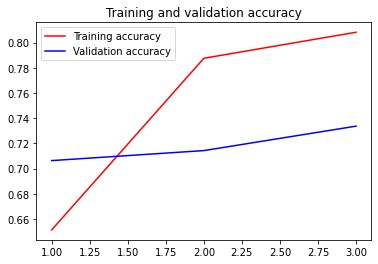

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
test_files = sorted(glob('test/*/*_image.jpg'))
#Obtain predictions from the test data
predictions = resnetv2_model.predict(test_generator)
print("Dimensions of the predictions array: {}".format(predictions.shape))
assert predictions.shape[0] == np.array(test_X).shape[0]

#Creating a dataframe and saving it as output
test_file = [fname[5:-10] for fname in test_files]
data = {'guid/image': test_file, 'label': np.argmax(predictions, axis=1).tolist()}
output_df = pd.DataFrame(data)
output_df.to_csv("Update_Team11.csv", index=False)

Dimensions of the predictions array: (2631, 3)


In [ ]:
#Loading a new model
resnetv2_model_iter2 = tf.keras.models.load_model('ResNetV2_model.h5')
resnetv2_model_iter2.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=5e-4)
loss = tensorflow.keras.losses.CategoricalCrossentropy()

resnetv2_model_iter2.compile(optimizer = opt, 
                       loss = loss, 
                       metrics = ["accuracy"])

lor = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.2, patience=2, verbose=1,
    mode='auto', min_delta=0.001, min_lr=0)

checkpoint1 = tf.keras.callbacks.ModelCheckpoint(
    "ResNetV2_model_iter2.h5", monitor='val_accuracy', verbose=1, save_best_only=False,
    save_weights_only = False, mode='auto', save_freq='epoch')

history_2 = resnetv2_model_iter2.fit(
            train_generator,
            validation_data = val_generator,
            epochs = 10,
            verbose = 1, shuffle=True,
            callbacks = [lor, checkpoint1])

In [ ]:
#Loading test dataset images
test_X = np.array(np.load("test_xupd.npy"))
test_datagen = ImageDataGenerator(rescale=1.0/255.)

test_generator = test_datagen.flow(test_X, batch_size = 32, shuffle=False)

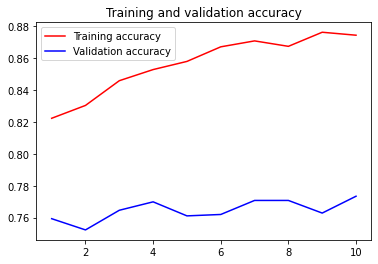

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()